In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

%matplotlib inline

# Particle ID Using Decision Trees

In this example, we're going to be using decision trees to analyze simulated data from particle detectors.  The particles traverse the detector, depositing energy via ionization and radiation as they go.  The detector response to this energy deposition is recorded and can be used to infer what type of particle deposited the energy.

We should be able to do a very effective job of classifying particles by dividing the data into distinct final states via the use of decision trees.  Our challenge in this part of the problem is to get a feeling for how a "normal" decision tree can tend to overtrain and how to combat that tendency to overtrain.

This data sample has 500 thousand entries, each of which has seven variables:

1. "id": This is the PDG (Particle Data Group) particle id.  The number corresponds to particle type and the sign gives the charge (particles that can have charge magnitude greater than 1 are handled differently): -11 = electron, 211 = pion, 321 = kaon, 2212 = proton.
2. "p": The particle's measured momentum.
3. "theta": The polar angle of the particle's momentum vector relative to the incoming beam axis.
4. "beta": The particle's velocity divided by the speed of light (aka, p/E)
5. "nphe": The number of photo electrons collected in one part of the detector apparatus.
6. "ein": The energy deposited in the inner calorimeter detector.
7. "eout": The energy deposited in the outer calorimeter detector.

In some cases, these variables are zero.  This can either mean that the actual value was zero, but it can also mean that the detector did not record a value due to inefficiency.  You should also expect that the data itself has noise coming from various sources.  This makes accurate particle identification a challenge, but likely not an insurmountable one!

***
***
# Read the data file and organize our data

The data is stored in a CSV file, which we're not quite good at extracting.

In [2]:
nExamples = 100000
datasetTrain = pd.read_csv("particleID/train.csv",nrows=nExamples)
datasetTest = pd.read_csv("particleID/test.csv",nrows=nExamples)

print("Header: ", datasetTrain.head(5))
print("\nDescription: ", datasetTrain.describe())

# class distribution
print("\nClass description: ", datasetTrain.groupby('id').size())

Header:       id         p     theta      beta  nphe       ein      eout
0   211  0.780041  1.081480  0.989962     0  0.000000  0.000000
1   211  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  2212  0.773022  0.185953  0.642428     4  0.101900  0.000000
3   211  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  2212  2.123290  0.337332  0.908652     0  0.034379  0.049256

Description:                    id              p          theta           beta  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      992.069800       1.231136       0.488721       0.899760   
std       971.914274       0.742582       0.294064       0.113260   
min       -11.000000       0.210117       0.093336       0.550041   
25%       211.000000       0.666056       0.281363       0.837612   
50%       211.000000       1.066450       0.404475       0.946710   
75%      2212.000000       1.655450       0.611951       0.985656   
max      2212.000000       5.028150     

***
***
# Massage data to obtain testing and training arrays

We'll drop some variables and create some indexing arrays to allow us to select out certain types of particles.

In [3]:
X = datasetTrain.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_train = X.values

print(X)

X = datasetTest.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_test = X.values



# Two forms of the 
y = pd.get_dummies(datasetTrain.id)
print(y)
y_train = y.values[:,2]
elecIdx = np.array(y.values[:,0]==1)
pionIdx = np.array(y.values[:,1]==1)
kaonIdx = np.array(y.values[:,2]==1)
protIdx = np.array(y.values[:,3]==1)

y = pd.get_dummies(datasetTest.id)
y_test = y.values[:,2]

elecIdxTest = np.array(y.values[:,0]==1)
pionIdxTest = np.array(y.values[:,1]==1)
kaonIdxTest = np.array(y.values[:,2]==1)
protIdxTest = np.array(y.values[:,3]==1)

              p      beta
0      0.780041  0.989962
1      0.260929  0.902450
2      0.773022  0.642428
3      0.476997  0.951471
4      2.123290  0.908652
...         ...       ...
99995  1.380330  1.012120
99996  0.903334  0.902495
99997  2.348210  0.942891
99998  0.457160  0.962500
99999  1.317920  0.825011

[100000 rows x 2 columns]
       -11     211    321    2212
0          0      1      0      0
1          0      1      0      0
2          0      0      0      1
3          0      1      0      0
4          0      0      0      1
...      ...    ...    ...    ...
99995      0      1      0      0
99996      0      0      1      0
99997      0      0      0      1
99998      0      1      0      0
99999      0      0      0      1

[100000 rows x 4 columns]


# Start off with some figures to see what's happening

We're going to focus on the relationship between the particle's momentum magnitude and its velocity.  You can think of this as a proxy for energy vs momentum, which should be very sensitive to particle mass.  We see here that this rule of thumb is indeed good for low momentum, but it is not so good as a discriminating variable at high momenta.

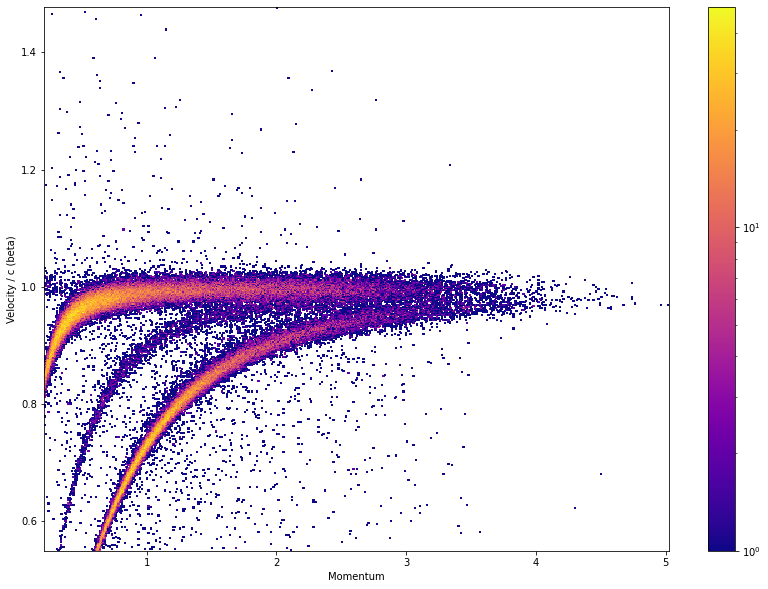

In [4]:
fig = plt.figure(figsize=(14,10))
plt.hist2d(datasetTrain.p,datasetTrain.beta,bins=500,cmap='plasma',norm=colors.LogNorm())
plt.xlabel("Momentum")
plt.ylabel("Velocity / c (beta)")
cb = plt.colorbar()
plt.show()

# Now let's plot the data as separate classes

This allows us to gain a bit more insight into what we're looking at.

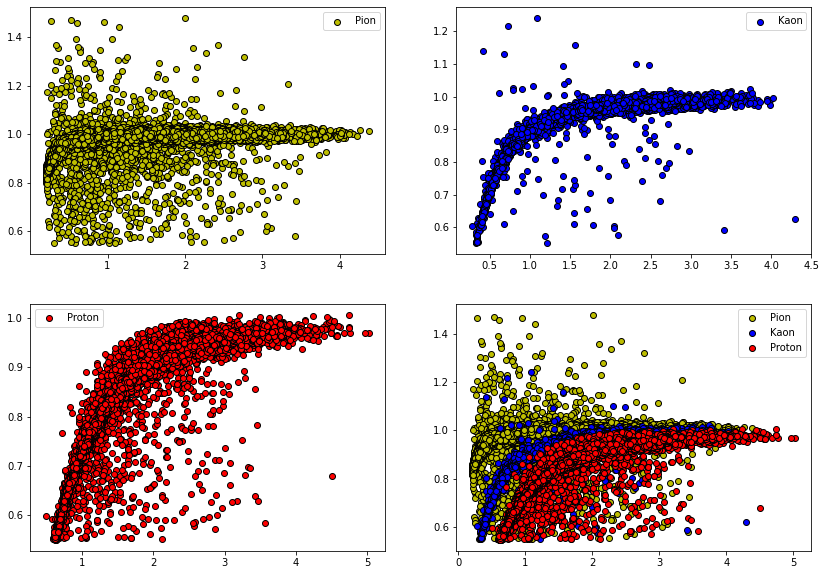

In [5]:
fig, ax = plt.subplots(2,2,figsize=(14,10))

ax[0,0].scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
ax[0,0].legend()
ax[0,1].scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
ax[0,1].legend()
ax[1,0].scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
ax[1,0].legend()
ax[1,1].scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
ax[1,1].scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
ax[1,1].scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
ax[1,1].legend()
plt.show()

***
***
# Create and train a decision tree

The `scikit-learn` decision tree is both well documented and very fast to train!  Let's start with some of the basic parameters:

1. max_depth = the maximum depth allowed for the tree
2. min_samples_split = the minimum number of examples that collect in a node before it can be split
3. min_samples_leaf = the minimum number of examples in a node to allow it to become a terminal node
4. max_leaf_nodes = the overall maximum number of leaf nodes to allow
5. class_weights = weights to apply to each class in case the number of examples is not uniform over classes

In [8]:
maxDepth = 5
minSS = 2  #Minimum samples required to allow a node split
minSL = 1  #Minimum samples required for a leaf (terminal node)
maxLeaf = None #Maximum number of leaves in the tree
cWeights = {0:1, 1:19}

dTree = DecisionTreeClassifier(random_state=0,
                               max_depth=maxDepth,
                               min_samples_split=minSS,
                               min_samples_leaf=minSL, 
                               max_leaf_nodes=maxLeaf,
                               class_weight=cWeights)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 19}, max_depth=5, random_state=0)

In [9]:
print(dTree.get_depth())
print(dTree.get_n_leaves())

5
30


***
***
# Calculate and report the accuracy of this trained tree

In [10]:
predictions = dTree.predict_proba(X_train)
predictionsBinary = dTree.predict(X_train)

print("Training Dataset: ")
print("Total Accuracy: ",accuracy_score(y_train,predictionsBinary))
print("Kaon Accuracy: ",accuracy_score(y_train[kaonIdx],predictionsBinary[kaonIdx]))
print("Pion Accuracy: ",accuracy_score(y_train[pionIdx],predictionsBinary[pionIdx]))
print("Proton Accuracy: ",accuracy_score(y_train[protIdx],predictionsBinary[protIdx]))

Training Dataset: 
Total Accuracy:  0.85408
Kaon Accuracy:  0.9577494692144374
Pion Accuracy:  0.898442090269741
Proton Accuracy:  0.7761401700592631


Testing Dataset: 
Total Accuracy:  0.85466
Kaon Accuracy:  0.9514310494362532
Pion Accuracy:  0.8993839835728953
Proton Accuracy:  0.7783204623331458


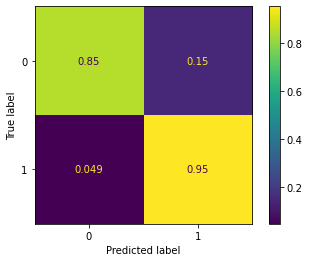

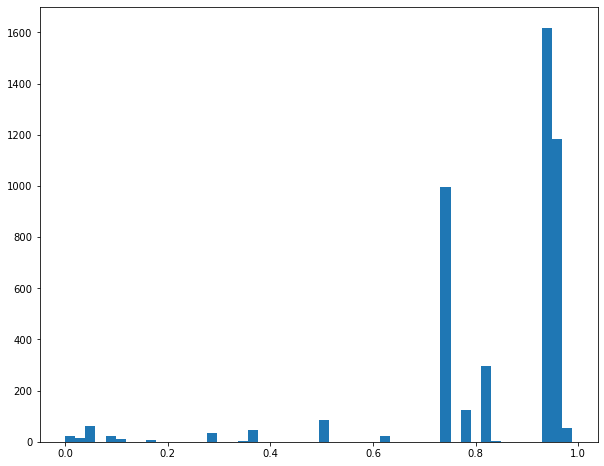

In [11]:
predictions = dTree.predict_proba(X_test)
predictionsBinary = dTree.predict(X_test)

print("Testing Dataset: ")
print("Total Accuracy: ",accuracy_score(y_test,predictionsBinary))
print("Kaon Accuracy: ",accuracy_score(y_test[kaonIdxTest],predictionsBinary[kaonIdxTest]))
print("Pion Accuracy: ",accuracy_score(y_test[pionIdxTest],predictionsBinary[pionIdxTest]))
print("Proton Accuracy: ",accuracy_score(y_test[protIdxTest],predictionsBinary[protIdxTest]))

cm = plot_confusion_matrix(dTree, X_test, y_test,normalize='true')  
plt.show()

fig = plt.figure(figsize=(10,8))
plt.hist(predictions[kaonIdxTest][:,1],bins=50)
plt.show()

***
***
# Draw the tree structure

Warning: this is very slow if you have a very deep tree!

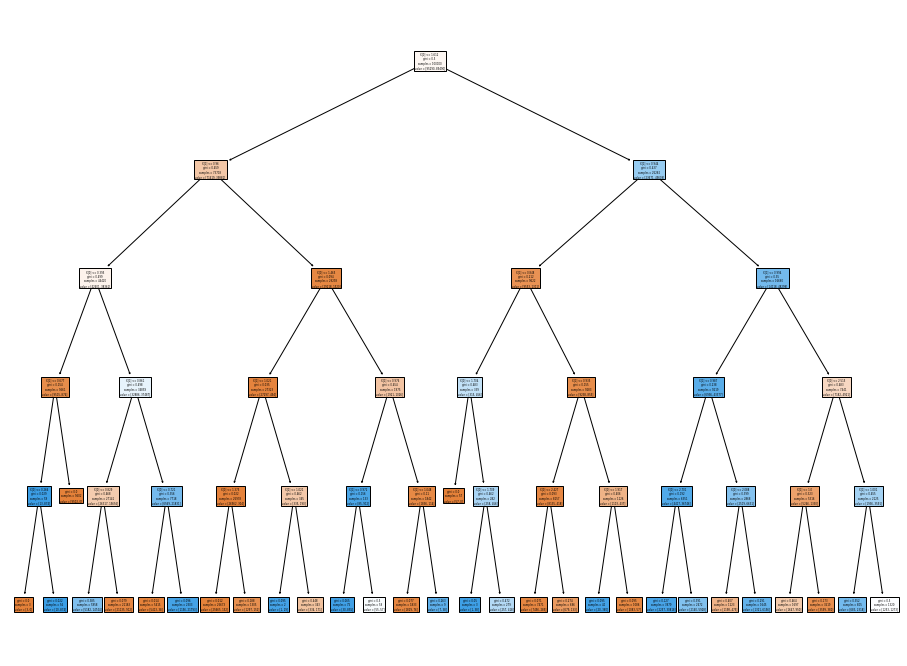

In [12]:
if maxDepth < 8:
    plt.figure(figsize=(16,12))
    plot_tree(dTree,filled=True)
    plt.show()

***
***
# Finally, make plots of the decision tree boundaries


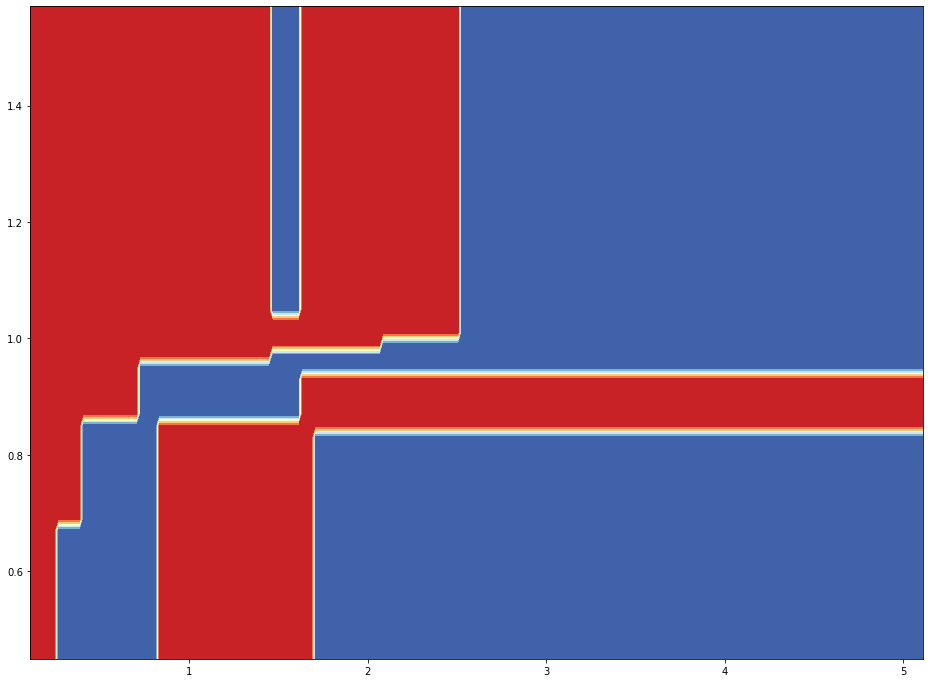

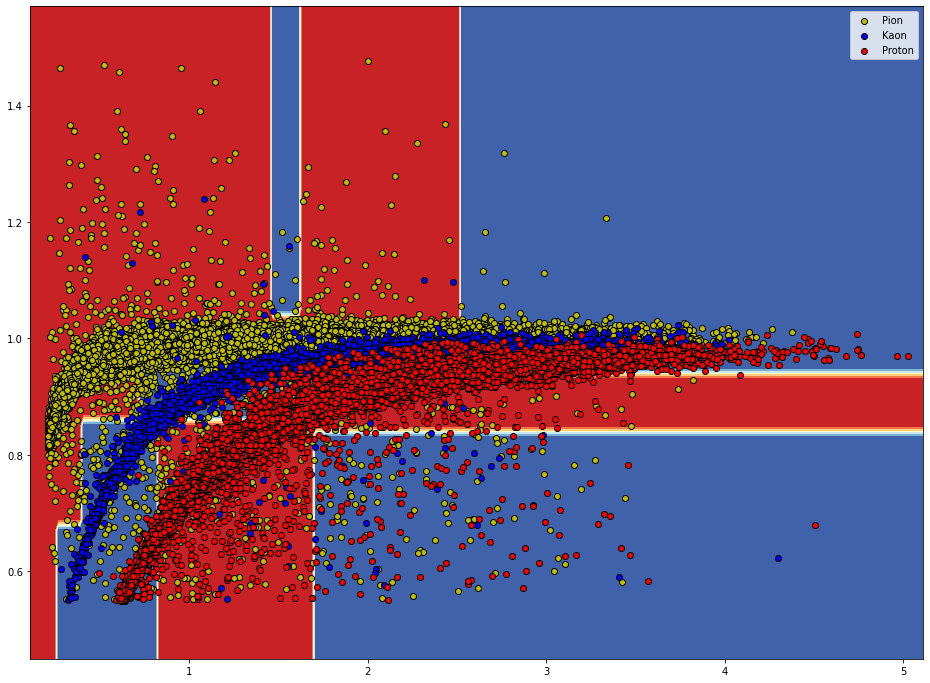

In [13]:
# Parameters
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02


x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

fig = plt.figure(figsize=(16,12))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dTree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

fig = plt.figure(figsize=(16,12))

cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)



plt.scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
plt.scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
plt.scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
plt.legend()